In [1]:
import os 
import wget
import gzip
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy
import tensorflow as tf
from collections import defaultdict
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer
from scipy.spatial import distance

Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_6/data` folder automatically.

In [2]:
filenames = [
    'epinions.txt',
    'network_trust.txt'
]

dataDir = './data/epinions_data'
url = 'http://jmcauley.ucsd.edu/pml_data/epinions_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

filenames = [
    'goodreads_reviews_comics_graphic.json.gz',
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")

Done!


# Factorization Machine (pyFM)

Parse the Goodreads comic book data (excluding review text)

In [3]:
def parseData(fname):
    for l in gzip.open(fname):
        d = eval(l)
        del d['review_text'] # Discard the reviews to save memory
        d['year'] = int(d['date_added'][-4:]) # Use this for exercises
        yield d

In [4]:
data = list(parseData(os.path.join(dataDir, "goodreads_reviews_comics_graphic.json.gz")))

In [5]:
random.shuffle(data)

For example...

In [6]:
data[0]

{'user_id': '53db0e2c455b735d4dff1d94f16e83ea',
 'book_id': '2070998',
 'review_id': 'db4dde76d544c750a86b12e28ed376c8',
 'rating': 4,
 'date_added': 'Wed Aug 18 17:22:13 -0700 2010',
 'date_updated': 'Fri Aug 20 08:23:45 -0700 2010',
 'read_at': 'Fri Aug 20 00:00:00 -0700 2010',
 'started_at': 'Wed Aug 18 00:00:00 -0700 2010',
 'n_votes': 0,
 'n_comments': 0,
 'year': 2010}

Utility data structures. Most importantly, each user and item is mapped to an ID from 1 to nUsers/nItems

In [7]:
inputs = [{'user_id': i['user_id'], 'book_id': i['book_id']}  for i in data]
outputs = [float(i['rating'])  for i in data]

Include features (user id and book id here, we can add more)

In [8]:
X_train, X_test = inputs[:400000], inputs[400000:]

In [9]:
y_train, y_test = outputs[:400000], outputs[400000:]

Transform input features

In [10]:
v = DictVectorizer().fit(inputs)
v.transform(X_train[:5]).shape

(5, 148658)

The length of features are #users + #items

In [11]:
nUsers = len(set(i['user_id'] for i in data))
nItems = len(set(i['book_id'] for i in data))
print(f"#users = {nUsers}, #items = {nItems}, sum = {nUsers + nItems}")

#users = 59347, #items = 89311, sum = 148658


Tansform all X_train and X_test inputs:

In [12]:
X_train = v.transform(X_train)
X_test = v.transform(X_test)

Initialize FM model

In [13]:
fm = pylibfm.FM(num_factors=10, num_iter=100, verbose=False, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")

Train the model

In [14]:
fm.fit(X_train, y_train)

Extract predictions on the test set

In [15]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [16]:
y_pred = fm.predict(X_test)
MSE(y_pred, y_test)

0.9645106868462364

# Exercises

### 6.1

Simple example, just incorporating a one-hot encoding of the year (see data extraction in examples above)

In [17]:
inputs = [{'user_id': i['user_id'], 'book_id': i['book_id'], 'year': str(i['year'])}  for i in data]
outputs = [float(i['rating'])  for i in data]

In [18]:
X_train, X_test = inputs[:400000], inputs[400000:]
y_train, y_test = outputs[:400000], outputs[400000:]

In [19]:
v = DictVectorizer().fit(inputs)

In [20]:
fm = pylibfm.FM(num_factors=10, num_iter=100, verbose=False, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")

In [22]:
fm.fit(v.transform(X_train), y_train)

In [23]:
y_pred_with_features = fm.predict(v.transform(X_test))
MSE(y_pred_with_features, y_test)

0.9480676688606394

### 6.2

Cold start plots. Count training instances per item (could also measure coldness per user if we had user features).

In [24]:
data[0]

{'user_id': 'ccf27886cb4d36f519e15e583b04301f',
 'book_id': '31979',
 'review_id': '1695f6a34ebff441a0d66bb951c2b9ec',
 'rating': 4,
 'date_added': 'Mon Jun 22 07:39:24 -0700 2015',
 'date_updated': 'Mon Jun 22 07:40:37 -0700 2015',
 'read_at': 'Sun Jun 21 00:00:00 -0700 2015',
 'started_at': '',
 'n_votes': 0,
 'n_comments': 0,
 'year': 2015}

In [25]:
nTrainPerItem = defaultdict(int)
for d in X_train:
    nTrainPerItem[d['book_id']] += 1

In [26]:
rmsePerNtrainFeatures = defaultdict(list)
rmsePerNtrain = defaultdict(list)
for d,y,ypf,yp in zip(X_test,y_test,y_pred_with_features,y_pred):
    e2_features = (y-ypf)**2
    e2 = (y-yp)**2
    nt = nTrainPerItem[d['book_id']]
    if nt < 5:
        rmsePerNtrainFeatures[str(nt)].append(e2_features)
        rmsePerNtrain[str(nt)].append(e2)
    elif nt < 10:
        rmsePerNtrainFeatures['5-9'].append(e2_features)
        rmsePerNtrain['5-9'].append(e2)
    elif nt < 20:
        rmsePerNtrainFeatures['10-19'].append(e2_features)
        rmsePerNtrain['10-19'].append(e2)
    else:
        rmsePerNtrainFeatures['20+'].append(e2_features)
        rmsePerNtrain['20+'].append(e2)

In [27]:
for r in rmsePerNtrain:
    rmsePerNtrainFeatures[r] = sum(rmsePerNtrainFeatures[r]) / len(rmsePerNtrainFeatures[r])
    rmsePerNtrain[r] = sum(rmsePerNtrain[r]) / len(rmsePerNtrain[r])

In [28]:
rmsePerNtrain

defaultdict(list,
            {'20+': 0.923331064449279,
             '5-9': 0.9822351777577868,
             '0': 1.0450980588716776,
             '10-19': 0.9656318547015045,
             '3': 1.0332167629789628,
             '1': 1.0403429296610613,
             '2': 1.0099343996002346,
             '4': 0.977248791088353})

In [29]:
Xlab = ['0','1','2','3','4','5-9','10-19','20+']
X = [0,1,2,3,4,5.5,7,8.5] # Average of above ranges
YF = [rmsePerNtrainFeatures[x] for x in Xlab]
Y = [rmsePerNtrain[x] for x in Xlab]

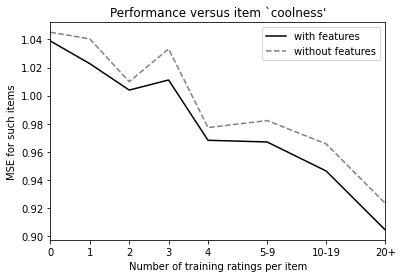

In [30]:
plt.xlim(0, max(X))
plt.plot(X,YF,color='k',label='with features')
plt.plot(X,Y,color='grey',linestyle='--',label='without features')
plt.xticks(X,Xlab)
plt.xlabel("Number of training ratings per item")
plt.ylabel("MSE for such items")
plt.title("Performance versus item `coolness'")
plt.legend(loc="best")
plt.show()

### 6.3

Read social data from epinions

In [6]:
userIDs = {}
itemIDs = {}
interactions = []

socialTrust = defaultdict(set)

f = open(os.path.join(dataDir, "epinions_data/epinions.txt"), 'rb')
header = f.readline()

for l in f:
    try:
        l = l.decode('utf-8')
        l = l.split()
    except Exception as e:
        continue
    i = l[0]
    u = l[1]
    
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((u,i))

f.close()

f = open(os.path.join(dataDir, "epinions_data/network_trust.txt"), 'r')
for l in f:
    try:
        u,_,v = l.strip().split()
    except Exception as e:
        continue
    if u in userIDs and v in userIDs:
        socialTrust[u].add(v)
        
f.close()

In [7]:
random.shuffle(interactions)

In [8]:
items = list(itemIDs.keys())

BPR model. First we'll use a regular BPR model just to assess similarity between friends' latent representations. Later we can implement different social sampling assumptions just by passing different samples to the same model.

In [9]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [10]:
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])

        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

First, train a regular BPR model (no social terms)

In [12]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelBPR = BPRbatch(10, 0.00001)

In [13]:
nTrain = int(len(interactions) * 0.9)
nTest = len(interactions) - nTrain
interactionsTrain = interactions[:nTrain]
interactionsTest = interactions[nTrain:]

In [14]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i in interactionsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

In [15]:
for i in range(100):
    obj = trainingStepBPR(modelBPR, interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.5597093
iteration 20, objective = 0.53543884
iteration 30, objective = 0.52609086
iteration 40, objective = 0.53415626
iteration 50, objective = 0.5446614
iteration 60, objective = 0.542109
iteration 70, objective = 0.5466399
iteration 80, objective = 0.5449675
iteration 90, objective = 0.5424055
iteration 100, objective = 0.54575086


In [16]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for u,i in interactionsTest:
    interactionsTestPerUser[u].add(i)
    itemSet.add(i)

In [17]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(itemSet.difference(interactionsTestPerUser[u]),N)
    for i,j in zip(positive,negative):
        si = model.predict(userIDs[u], itemIDs[i]).numpy()
        sj = model.predict(userIDs[u], itemIDs[j]).numpy()
        if si > sj:
            win += 1
    return win/N

In [18]:
def AUC(model):
    av = []
    for u in interactionsTestPerUser:
        av.append(AUCu(model, u, 10))
    return sum(av) / len(av)

In [19]:
AUC(modelBPR)

0.6736911450487991

Compute similarities among friends' latent representations

In [20]:
sims = []
simFriends = []
while len(sims) < 10000:
    try:
        u,i = random.choice(interactions)
        v = random.sample(socialTrust[u],1)[0] # trust link
        j = random.sample(itemsPerUser[v],1)[0] # friend's item
        k = random.choice(items) # random item
    except Exception as e:
        continue
    s1 = 1 - distance.cosine(modelBPR.gammaI[itemIDs[i]],modelBPR.gammaI[itemIDs[k]])
    s2 = 1 - distance.cosine(modelBPR.gammaI[itemIDs[i]],modelBPR.gammaI[itemIDs[j]])
    if s1 > 1:
        print("?")
        break
    sims.append(s1)
    simFriends.append(s2)

Similarity between randomly chosen pairs of items

In [21]:
sum(sims)/len(sims)

0.0012022802943294436

Similarity between an item and one consumed by a friend

In [22]:
sum(simFriends)/len(simFriends)

0.041558134568962124

(similarity is not particularly high, but still significantly higher than random pairs)

### 6.4

Implement the social model. Uses the model above, just with different samples.

In [23]:
def trainingStepBPRsocial(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        while len(sampleU) < Nsamples/2:
            try:
                u,i = random.choice(interactions) # positive sample
                v = random.sample(socialTrust[u],1)[0] # trust link
                j = random.sample(itemsPerUser[v],1)[0] # friend's item
                k = random.choice(items) # negative item
                if j in itemsPerUser[u] or k in itemsPerUser[u]:
                    continue
            except Exception as e:
                continue
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i]) # Positive
            sampleJ.append(itemIDs[j]) # greater than social
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[j]) # Social
            sampleJ.append(itemIDs[k]) # greater than negative        

        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [24]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelBPRsocial = BPRbatch(10, 0.00001)

In [25]:
for i in range(100):
    obj = trainingStepBPRsocial(modelBPRsocial, interactions)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.644005
iteration 20, objective = 0.6152606
iteration 30, objective = 0.6268428
iteration 40, objective = 0.63128346
iteration 50, objective = 0.63005745
iteration 60, objective = 0.6233824
iteration 70, objective = 0.61877596
iteration 80, objective = 0.6176447
iteration 90, objective = 0.6122354
iteration 100, objective = 0.6103236


In [26]:
AUC(modelBPRsocial)

0.6301543550923024